In [1]:
# What needs to be done when Jupyter Server is up and running
# - upload data set to jupyter server (to 'data' folder)
# - upload columns definition to jupyter server (to 'data' folder)

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import seaborn as sns
import numpy as np
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator, VectorAssembler, IndexToString
from pyspark.ml.classification import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support

In [3]:
# initialization of PySpark session
sc = SparkSession.builder\
    .appName("CLASSIFICATION_WITH_PYSPARK") \
    .master("local[*]") \
    .getOrCreate()

In [4]:
# Create expression to rename columns. Original columns are present in 'columns.txt' and they 
# need to be processed first.

with open('data/columns.txt') as f_columns:
    columns = [col.strip().replace(' ', '_').replace('-','_').replace('\'','') for col in f_columns.readlines()]

renaming_expression = ['_c{} as {}'.format(i, col) for i, col in enumerate(columns)]


In [5]:
# Load data set, rename columns and infer correct schema.
# There are two sets available - test and train. So data split was already done by authors of the data set.
# When one is doing split on his own, there are many things to consider to get the best (unbiased and most accurate) 
# estimate of performance for final classifier... Just for this exercise sake and to save some time, let's consider the 
# "split" to be done well, so we do not have to worry about "correctness" of our final performance estimate

train_set = sc.read.option("inferSchema", True).option("header", False)\
    .csv('data/census-income.data')\
    .selectExpr(renaming_expression)
test_set = sc.read.option("inferSchema", True).option("header", False)\
    .csv('data/census-income.test')\
    .selectExpr(renaming_expression)

In [6]:
# let's look at sample of the data first
train_set.show()

+---+--------------------+-------------+---------------+--------------------+-------------+----------------------------+--------------------+--------------------+---------------------+--------------------+--------------------+-------+-----------------------+-----------------------+---------------------------------+-------------+--------------+--------------------+--------------------+----------------------------+---------------------------+----------------------------------+---------------------------------------+---------------+----------------------------+----------------------------+------------------------------+-----------------------------+-----------------------------+-------------------------------+-----------------------+-----------------------+-----------------------+---------------------+--------------------+-----------------------------+-----------------------------------------+-----------------+--------------------+----+---------+
|age|     class_of_worker|industry_code|oc

In [7]:
# let's drop instance weight from sample (it is suggested in notes to data set)
train_set = train_set.drop("instance_weight")
test_set = test_set.drop("instance_weight")
columns.remove('instance_weight')

In [8]:
# Check for null data... It seems that there are no missing values. However, from the sample, it seems that few columns
# contain "?" value - this one is probably to indicate missing value...
train_set.select([F.count(F.when(F.isnan(c), c)).alias(c) for c in columns]).show()


+---+---------------+-------------+---------------+---------+-------------+----------------------------+--------------+-------------------+---------------------+----+---------------+---+-----------------------+-----------------------+---------------------------------+-------------+--------------+--------------------+----------------+----------------------------+---------------------------+----------------------------------+---------------------------------------+----------------------------+----------------------------+------------------------------+-----------------------------+-----------------------------+-------------------------------+-----------------------+-----------------------+-----------------------+---------------------+-----------+-----------------------------+-----------------------------------------+-----------------+--------------------+----+-----+
|age|class_of_worker|industry_code|occupation_code|education|wage_per_hour|enrolled_in_edu_inst_last_wk|marital_status|majo

In [9]:
# let's get some basic description for the train set (code for the test set is the same).
# This basic description could be also used as a first check of the train vs test set data - if there is something 
# wrong with them (I will skip that part for reasons listed in previous cell)

In [10]:
# print schema (test set has the same one) to check if data types for columns were properly inferred and columns 
# were renamed
train_set.printSchema()

root
 |-- age: integer (nullable = true)
 |-- class_of_worker: string (nullable = true)
 |-- industry_code: double (nullable = true)
 |-- occupation_code: double (nullable = true)
 |-- education: string (nullable = true)
 |-- wage_per_hour: double (nullable = true)
 |-- enrolled_in_edu_inst_last_wk: string (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- major_industry_code: string (nullable = true)
 |-- major_occupation_code: string (nullable = true)
 |-- race: string (nullable = true)
 |-- hispanic_Origin: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- member_of_a_labor_union: string (nullable = true)
 |-- reason_for_unemployment: string (nullable = true)
 |-- full_or_part_time_employment_stat: string (nullable = true)
 |-- capital_gains: double (nullable = true)
 |-- capital_losses: double (nullable = true)
 |-- divdends_from_stocks: double (nullable = true)
 |-- tax_filer_status: string (nullable = true)
 |-- region_of_previous_residence: strin

In [11]:
# print summary of our data for the train set (this is especially useful for numerical columns)
train_set.describe()\
    .show()

+-------+------------------+-------------------+------------------+------------------+--------------------+------------------+----------------------------+--------------+-------------------+---------------------+--------------------+---------------+-------+-----------------------+-----------------------+---------------------------------+-----------------+------------------+--------------------+------------------+----------------------------+---------------------------+----------------------------------+---------------------------------------+----------------------------+----------------------------+------------------------------+-----------------------------+-----------------------------+-------------------------------+-----------------------+-----------------------+-----------------------+---------------------+--------------------+-----------------------------+-----------------------------------------+------------------+--------------------+------------------+---------+
|summary|     

In [12]:
# let's print counts of rows and columns
print("There are {} columns and {} rows in the train set.".format(len(train_set.columns), train_set.count()))

There are 41 columns and 199523 rows in the train set.


In [13]:
# to see all (few) distinct variables for single column... 
train_set.select('migration_code_change_in_msa')\
    .distinct()\
    .show()

+----------------------------+
|migration_code_change_in_msa|
+----------------------------+
|                  MSA to MSA|
|               NonMSA to MSA|
|               Abroad to MSA|
|            Abroad to nonMSA|
|               MSA to nonMSA|
|             Not in universe|
|                           ?|
|            Not identifiable|
|                    Nonmover|
|            NonMSA to nonMSA|
+----------------------------+



In [14]:
# it is also possible to make a table with all distinct variables in column... this table can be easily collected...
train_set.select(*[F.collect_set(col).alias(col) for col in columns])\
    .show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------------------+--------------------+--------------------+---------------------+--------------------+--------------------+----------------+-----------------------+-----------------------+---------------------------------+--------------------+--------------------+--------------------+--------------------+----------------------------+---------------------------+----------------------------------+---------------------------------------+----------------------------+----------------------------+------------------------------+-----------------------------+-----------------------------+-------------------------------+-----------------------+-----------------------+-----------------------+---------------------+--------------------+-----------------------------+-----------------------------------------+-----------------+--------------------+------------+---

In [15]:
# Let's do exploratory analysis. This one can be latter use for feature selection, ML algorithm selection and 
# classifying problem definition...

# What will be done:
# View data distributions
# Identify skewed predictors
# Identify outliers

# Pandas for plotting will be used... note that in most cases, the data are first processed on cluster and then 
# converted to Pandas, so code can be used on larger data sets.
# When it is not possible (or not convenient) a (proper) subsample of data can be used...

# The exploratory analysis for test set is skipped for reasons explained earlier...

# parameters for plotting
fig_size=(20,20)

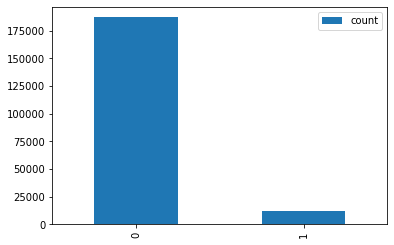

In [16]:
# let's see our outcomes we are going to predict... this can for example tell something about imbalance...
train_set.groupBy('class')\
    .count()\
    .toPandas()\
    .plot(kind='bar')

In [17]:
# let's convert our data into pandas for easier visualizations (in case of larger data set, we could use sample)
train_set_pd = train_set.toPandas()

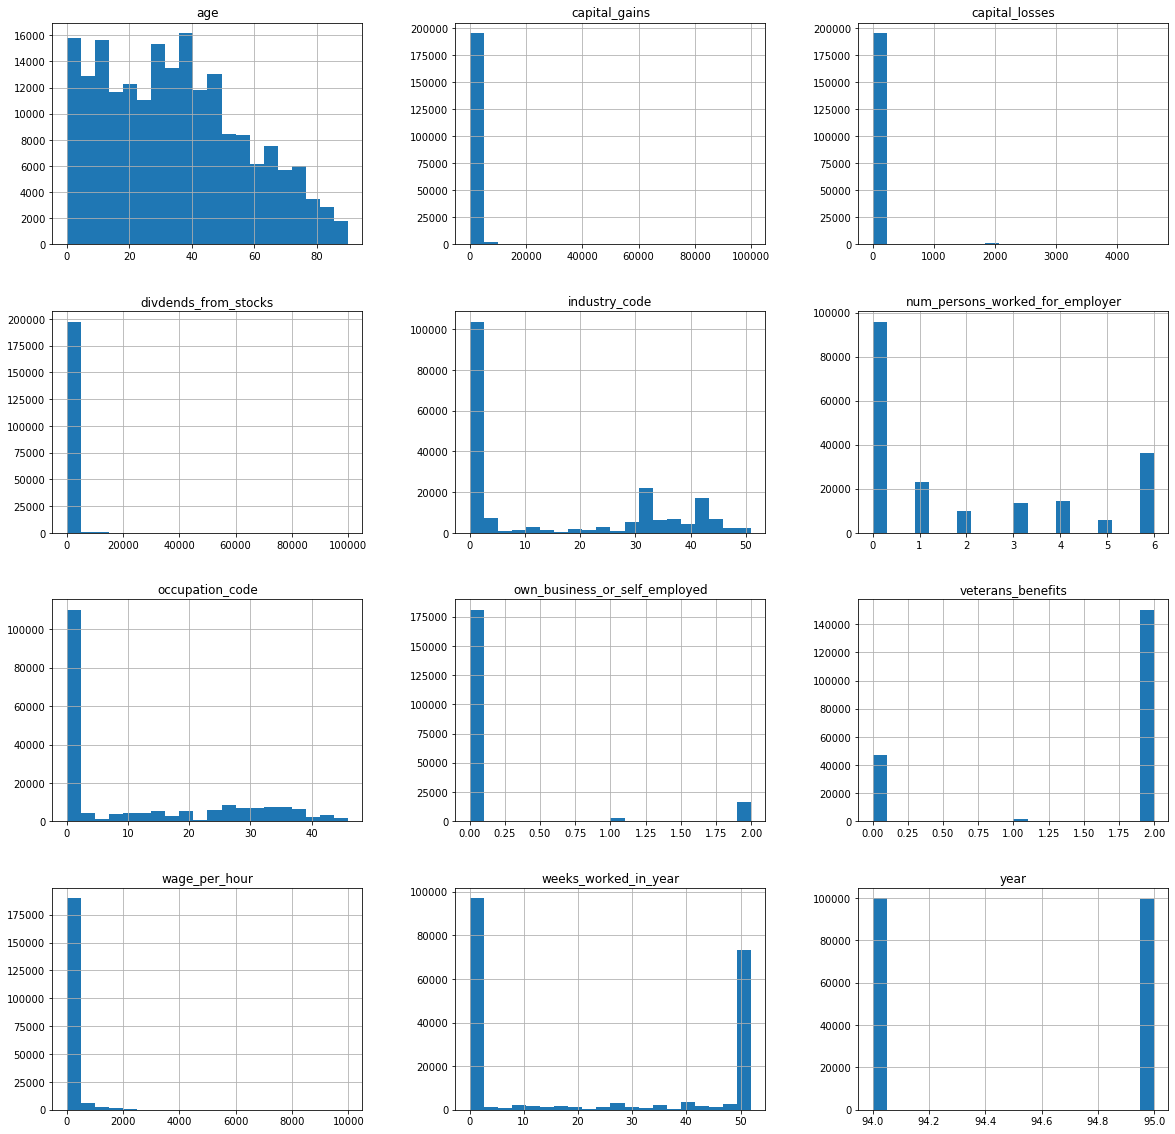

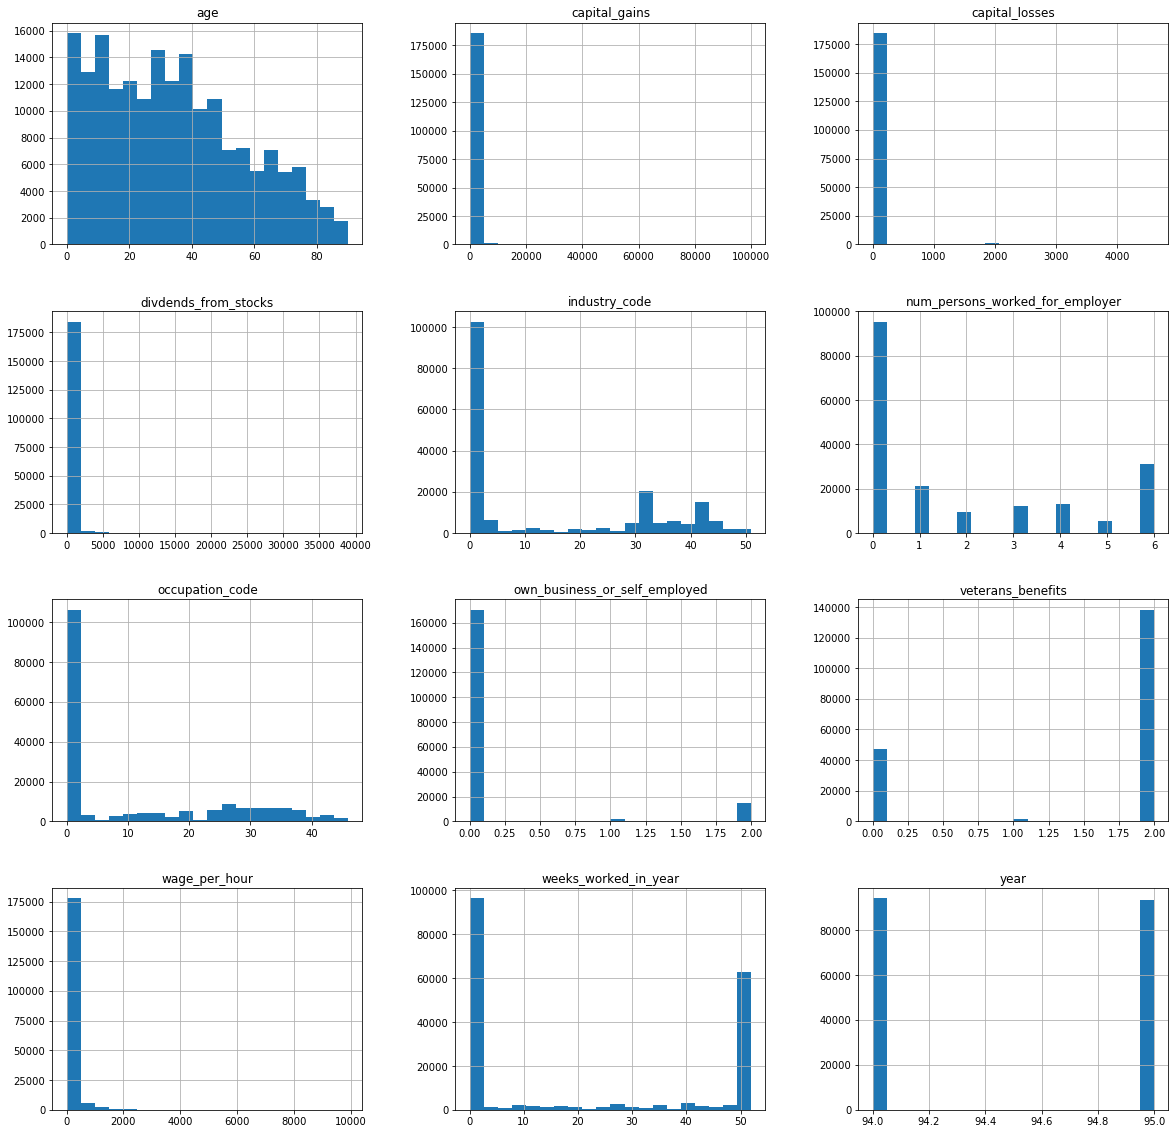

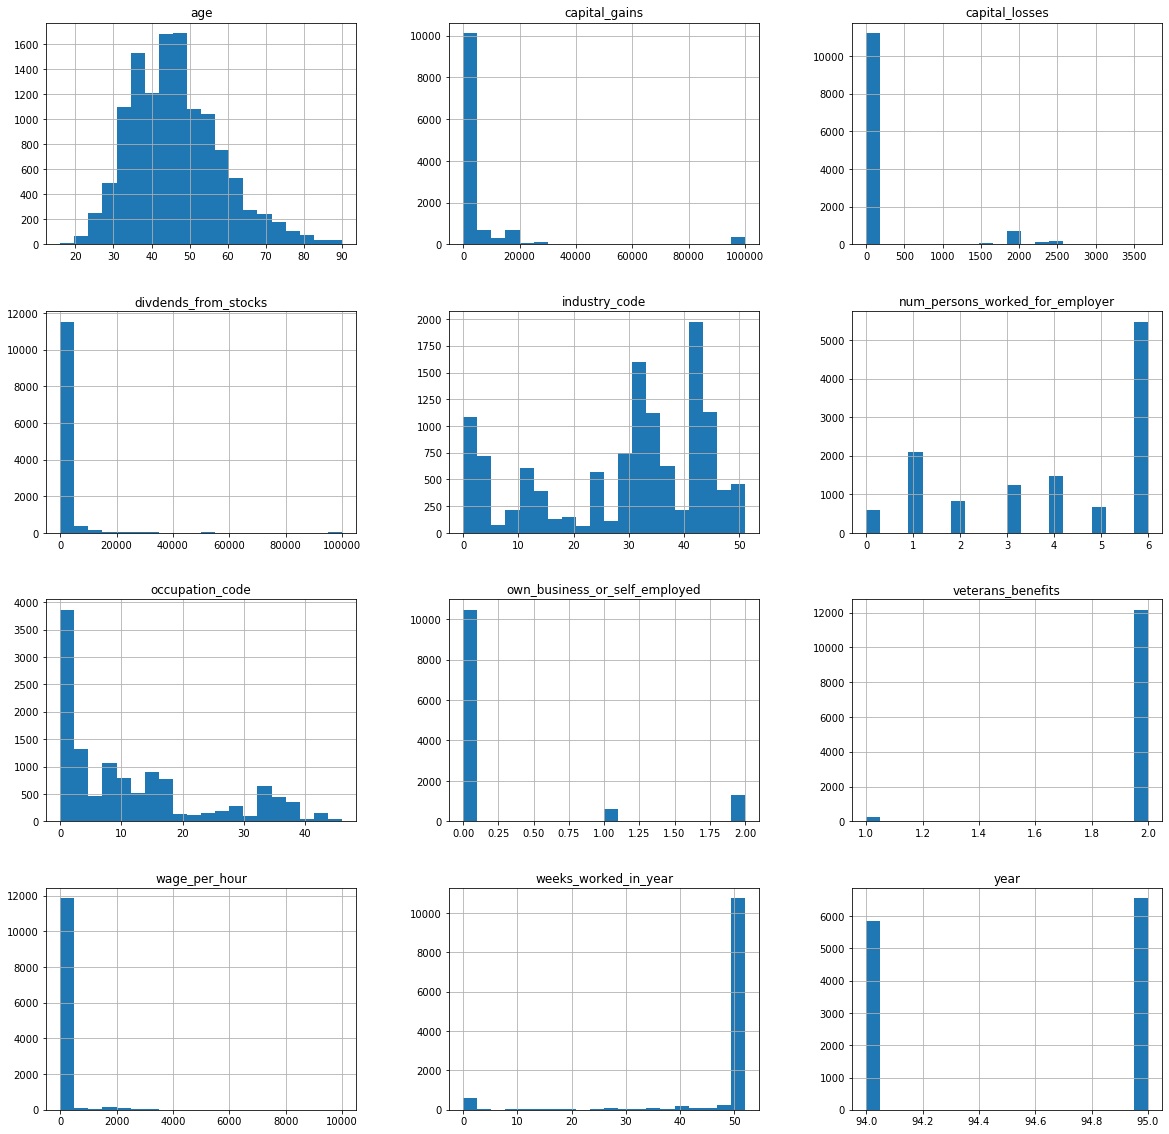

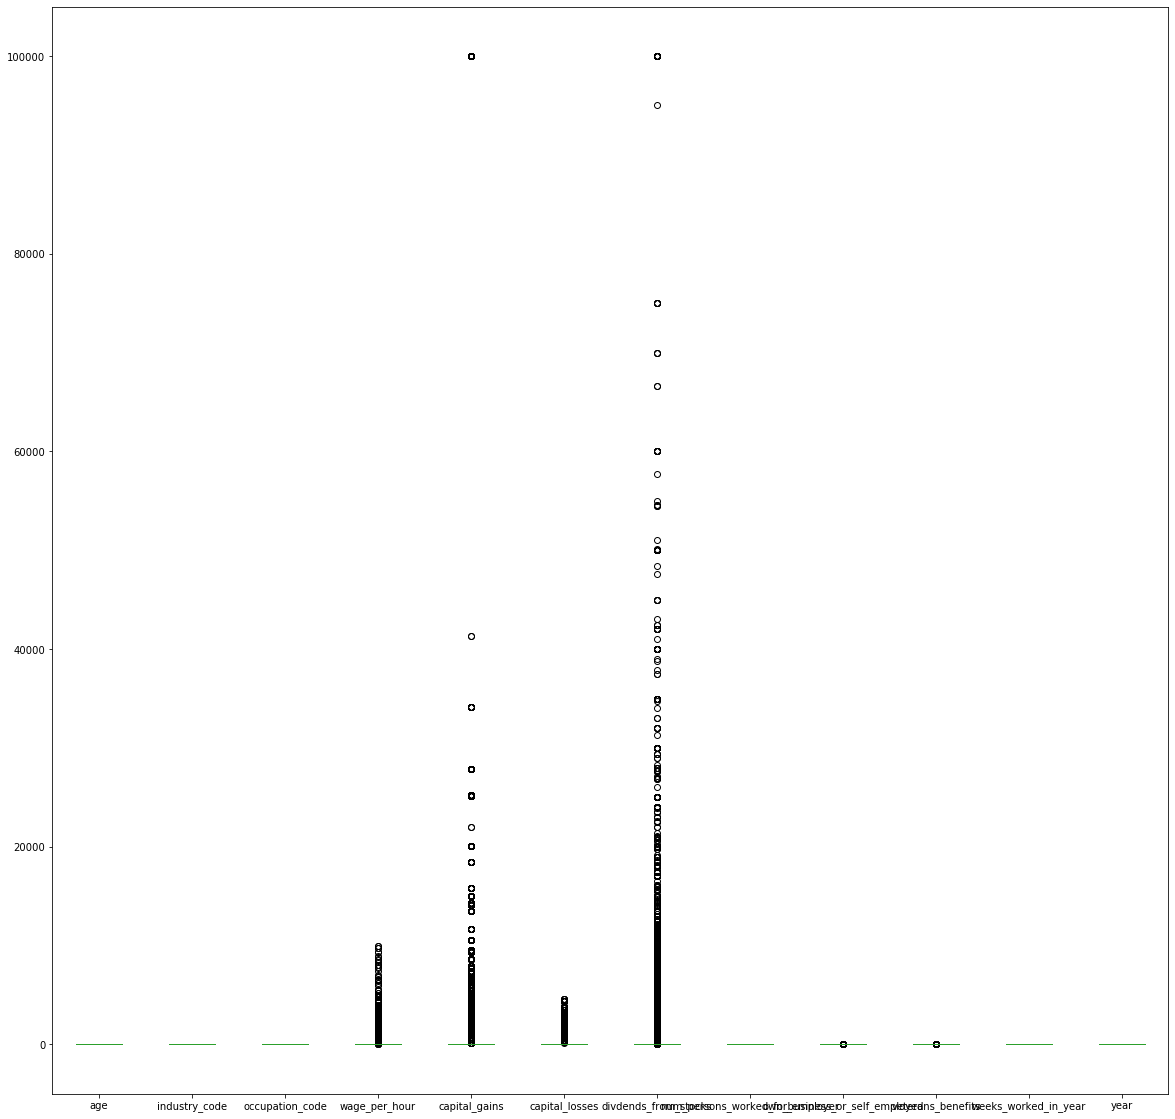

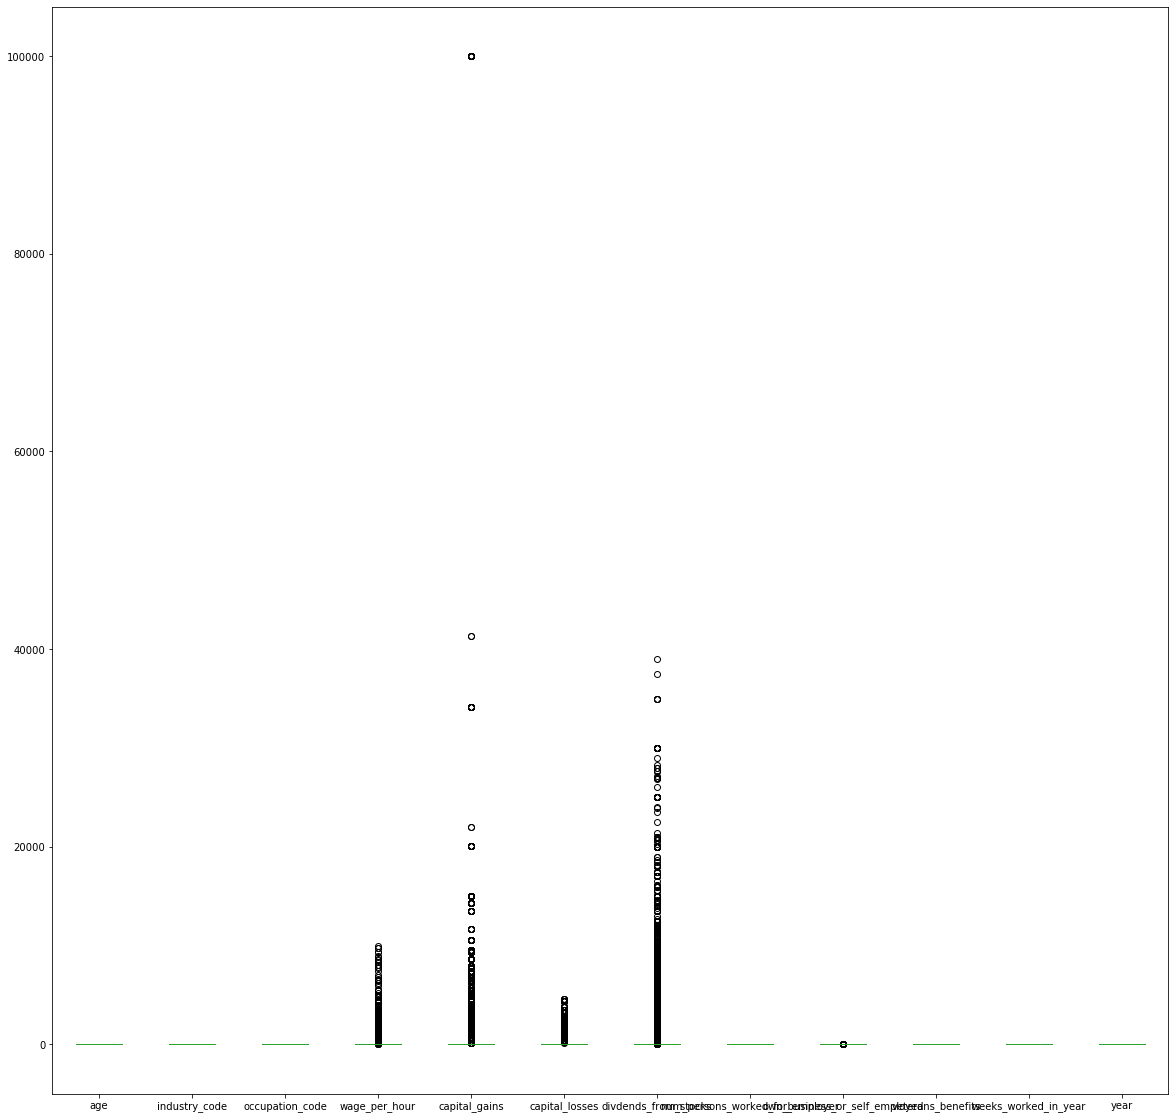

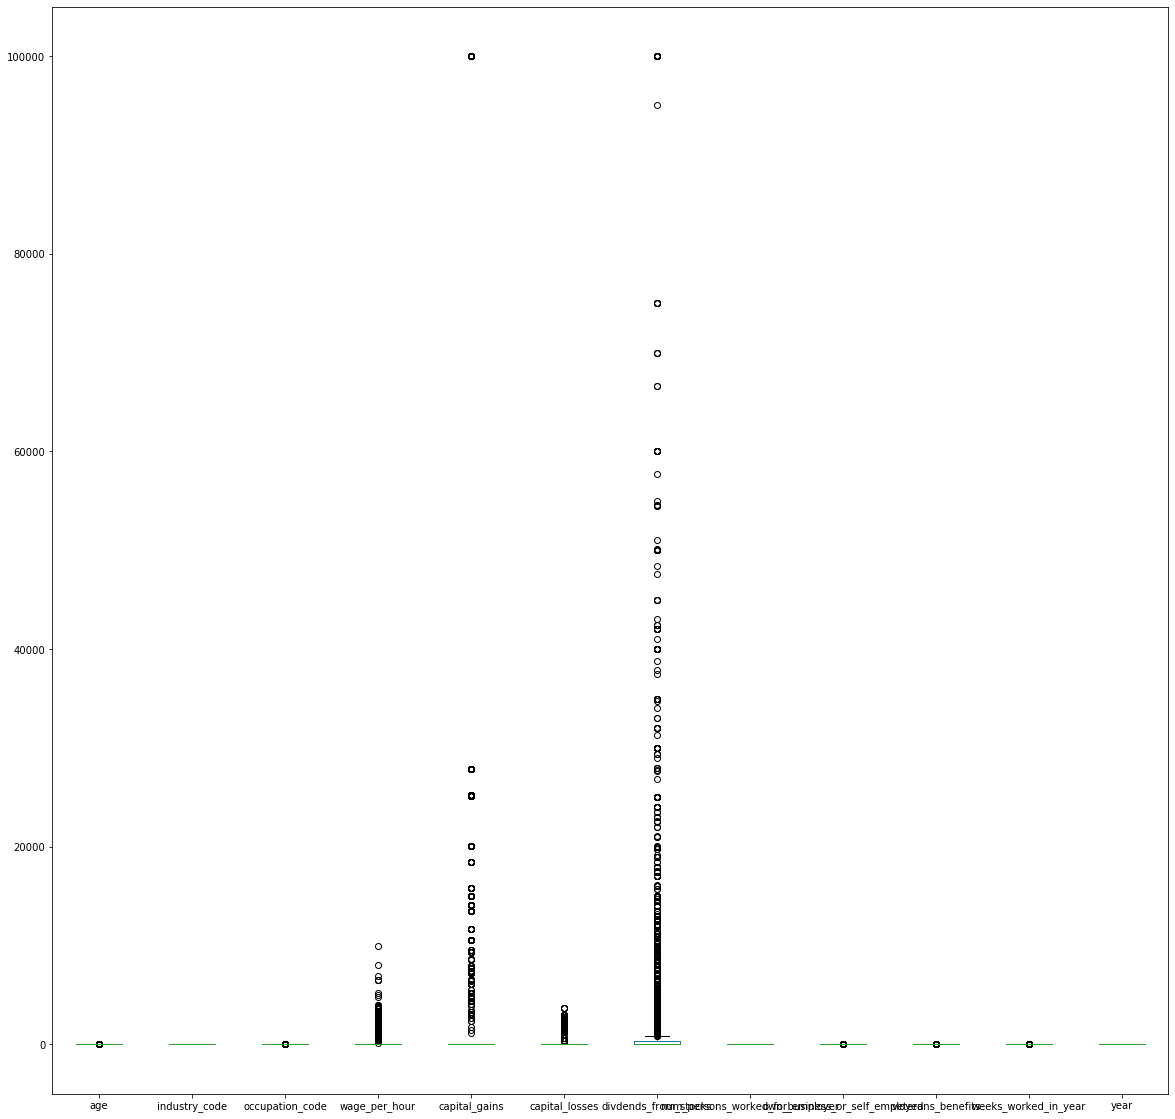

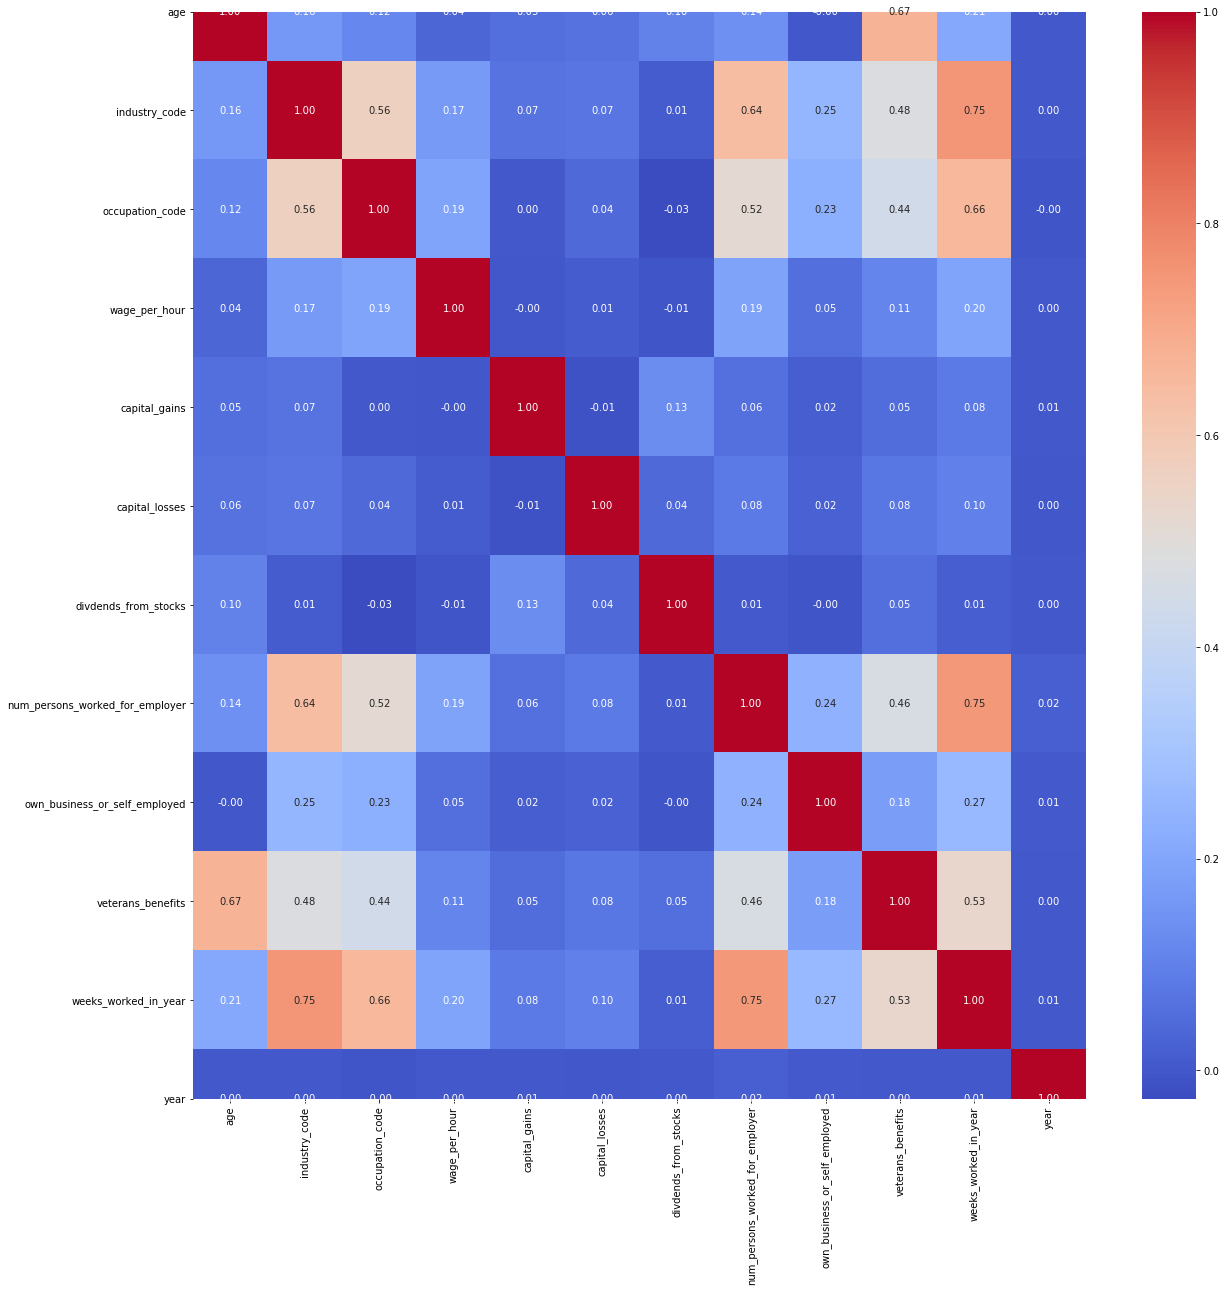

In [18]:
# let's take a look on distributions for each numerical variables
# show the distributions...

# using histograms...
# all data
train_set_pd.hist(bins=20, figsize=fig_size)
# data separated by outcome
train_set_pd.groupby('class').hist(bins=20, figsize=fig_size)

# using box plots...
# all data
train_set_pd.plot.box(figsize=fig_size)
# data separated by outcome
train_set_pd.groupby('class').plot.box(figsize=fig_size)

# correlation matrix between numerical values
plt.figure(figsize = fig_size)
sns.heatmap(train_set_pd.corr(), annot=True, fmt = ".2f", cmap = "coolwarm")

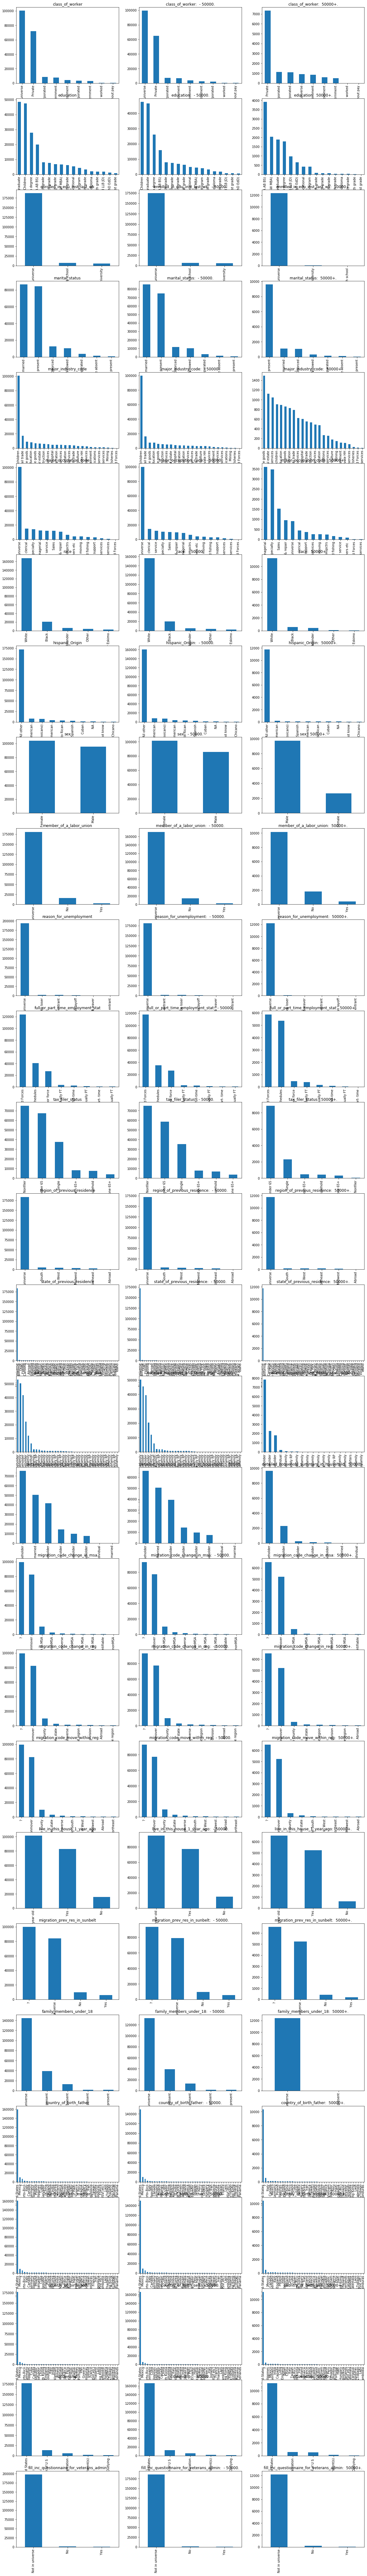

In [19]:
# let's take a look on distributions for each boolean/categorical variables

# get categorical and boolean features
cat_bool_col = [col[0] for col in train_set.dtypes if col[1] == 'string' and col[0] != 'class']

# group by values by outcome
train_set_pd_grouped = dict(list(train_set_pd.groupby(['class'])))
classes = list(train_set_pd_grouped.keys())

# create a one large plot
fig, ax = plt.subplots(len(cat_bool_col), 3, figsize=(20,150))

# for each variable add 3 plots
for num_var, var in enumerate(cat_bool_col):
    train_set_pd[var].value_counts().plot(kind="bar", ax=ax[num_var][0], title=var)
    for num_outcome, outcome in enumerate(classes):
        train_set_pd_grouped[outcome][var].value_counts().plot(kind="bar", ax=ax[num_var][1 + num_outcome], 
                                                               title='{}: {}'.format(var, outcome))

plt.show()

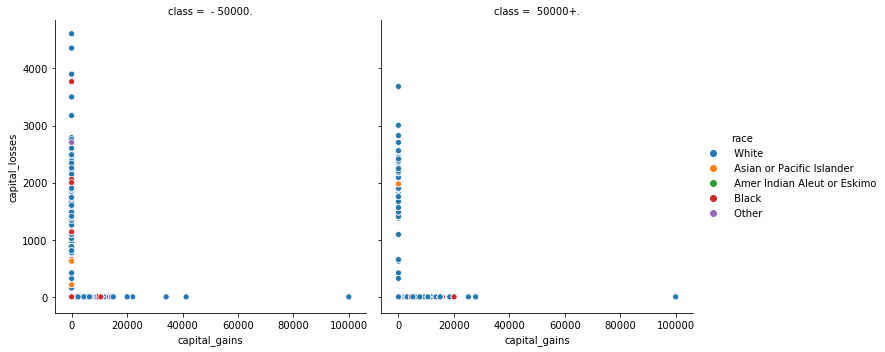

In [20]:
# it is also interesting to take a look on 

sns.relplot(x='capital_gains', y='capital_losses', hue='race', col='class', data=train_set_pd)

In [27]:
# Selection (by hand) of the most promising features and feature engineering is performed based on data analysis... 
# it is done in a way, that it should help model to generalize well.

# Any form of feature engineering, cleaning, and processing should be performed on the train set to prevent 
# the introduction of bias to model evaluation on the test set.

# For numerical:
# Those variables could be encoded to categorical: industry_code, occupation_code, own_business_or_self_employed.
# However, their are either imbalanced or there is too much infrequent categories... proper grouping would be hard
# Variables to remove due to small variance: wage_per_hour, capital_gains, capital_losses, divdends_from_stocks

# For categorical:
# Drop categorical columns - due to high class imbalance and/or does not make much sense to group minority instances
# as problem with unbalanced data may still prevail; or there are too many missing values
# - 'enrolled_in_edu_inst_last_wk'
# - 'major_industry_code'
# - 'major_occupation_code'
# - 'race'
# - 'hispanic_Origin'
# - 'member_of_a_labor_union'
# - 'reason_for_unemployment'
# - 'full_or_part_time_employment_stat'
# - 'region_of_previous_residence'
# - 'state_of_previous_residence'
# - 'migration_code_change_in_msa'
# - 'migration_code_change_in_reg'
# - 'migration_code_move_within_reg'
# - 'live_in_this_house_1_year_ago'
# - 'migration_prev_res_in_sunbelt'
# - 'country_of_birth_father'
# - 'country_of_birth_mother'
# - 'any_was_not_born_in_usa'
# - 'citizenship'
# - 'fill_inc_questionnaire_for_veterans_admin'
# Removed due to similarity with other feature: 'detailed_household_and_family_stat'

def process_data_frame(data_frame):
    """
    Process data frame - do feature selection and engineering
    :param data_frame: data set to be processed
    :return: processed data frame
    """
    
    # creates expression to map categorrical feature by given mapping
    def get_expression_for_mapping(mapping, column):
        return "case {} else 'other' end".format(" ".join([" ".join(["when {} = '{}' then '{}'".format(column, v, k) 
                                                                     for v in val]) for k, val in mapping.items()]))
    
    # creates expression to map categorical feature by given mapping to boolean
    def get_expression_for_boolean_mapping(values_to_be_set_true, column):
        return "case {} else False end".format(" ".join(["when {} = '{}' then True".format(column, v) 
                                                         for v in values_to_be_set_true]))
    # define mappings
    education_mapping = {'with_degree':  [' Doctorate degree(PhD EdD)', ' Associates degree-academic program', 
                                          ' Bachelors degree(BA AB BS)', ' Prof school degree (MD DDS DVM LLB JD)', 
                                          ' Associates degree-occup /vocational', 
                                          ' Masters degree(MA MS MEng MEd MSW MBA)'], 
                         'with_high_school': [' High school graduate'], 'with_college': [' Some college but no degree']}
    class_of_worker_mapping = [' Private']
    marital_status_mapping = [' Married-A F spouse present', ' Married-civilian spouse present']
    sex_mapping = [' Male']
    tax_filer_status_mapping = {'nonfiler': [' Nonfiler'], ' joint_under_65': [' Joint both under 65'], 
                                'single': [' Single']}
    detailed_household_summary_in_household_mapping = {'child': [' Child 18 or older', ' Child under 18 never married',
                                                                 ' Child under 18 ever married'], 
                                                       'householder': [' Householder'], 
                                                       'spouse_of_householder': [' Spouse of householder']}
    family_members_under_18_mapping = [' Not in universe']
    
    # do actual processing on data frame
    return data_frame\
        .select('age', 'num_persons_worked_for_employer', 
                F.expr("case when class == ' - 50000.' then 'No' else 'Yes' end").alias('has_over_50k'),
                F.expr('case when veterans_benefits == 2 then True else False end').alias('has_veterans_benefits'),
                F.expr('case when weeks_worked_in_year > 0 then True else False end').alias('worked_in_year'),
                F.expr(get_expression_for_mapping(tax_filer_status_mapping, 'tax_filer_status')).alias('tax_filer_status'), 
                F.expr(get_expression_for_mapping(education_mapping, 'education')).alias('education'),
                F.expr(get_expression_for_mapping(detailed_household_summary_in_household_mapping, 'detailed_household_summary_in_household')).alias('household_summary'),
                F.expr(get_expression_for_boolean_mapping(class_of_worker_mapping, 'class_of_worker')).alias('is_private_worker_class'),
                F.expr(get_expression_for_boolean_mapping(marital_status_mapping, 'marital_status')).alias('is_married'),
                F.expr(get_expression_for_boolean_mapping(sex_mapping, 'sex')).alias('is_male'),
                F.expr(get_expression_for_boolean_mapping(family_members_under_18_mapping, 'family_members_under_18')).alias('is_family_members_under_18_out_of_universe'))

# process data sets
processed_test_set = process_data_frame(test_set)
processed_train_set = process_data_frame(train_set)

# Note: it could be handy to do exploration and visualization of features once more as there may be some less visible 
# changes

In [22]:
# Most of ML algorithms (due to the training process and optimization criterion) have problems with unbalanced data sets. 
# I would argue that all available algorithms in Spark ML library would suffer in the current scenario 
# (tested just RF) and would learn to predict the majority class (with 95% accuracy in this case) without any data set 
# augmentation.  To complete this task one of the most straightforward data set augmentation technique 
# is used - oversampling of the minority class.

# compute count of instances per label
class_instances_counts = processed_train_set.groupBy('has_over_50k')\
    .count()\
    .collect()

# add them to dictionary
class_instances_counts_dict = {row['has_over_50k']: row['count'] for row in class_instances_counts}

# let's make balanced training set augmented
augmented_training_set = processed_train_set\
    .filter(F.col('has_over_50k') == 'Yes')\
    .sample(True, (class_instances_counts_dict['No']/class_instances_counts_dict['Yes']) / 2)\
    .union(processed_train_set)

In [28]:
# Random forests algorithm is used as a classifier. RFs are ensembles of decision trees. Random forests combine 
# many (uncorrelated) decision trees (sensitive to data sample) to reduce the risk of over-fitting. 
# Our data set would not require any further data processing (scaling or normalizing numerical features) except 
# one-hot encoding for categorical features. I went for this one as the cardinality of each remaining categorical 
# feature is low after processing, and the interpretation of something like 'has_high_school_education' seems 
# convenient to me. On top, this algorithm should scale really well with data.

# list of string columns to be indexes
string_cols = [col[0] for col in processed_train_set.dtypes if col[1] == 'string' and col[0] != 'has_over_50k']

# one-hot encoded features
one_hot_encoded_features = ["{}_encoded".format(col) for col in string_cols]

# get all features
num_bool_features = [col[0] for col in processed_train_set.dtypes if col[1] != 'string' and col[0] != 'has_over_50k'] \
                    + one_hot_encoded_features

# create indexer for categorical variables so they can be one-hot encoded
indexers = [StringIndexer(inputCol=col, outputCol="{}_index".format(col)) for col in string_cols]

# one-hot encode categorical features
encoder = OneHotEncoderEstimator(inputCols=["{}_index".format(col) for col in string_cols], 
                                 outputCols=one_hot_encoded_features)

# assemble all features into feature vector
features_assembler = VectorAssembler(inputCols = num_bool_features, outputCol = "features")

# Index labels, adding metadata to the label column.
label_indexer = StringIndexer(inputCol="has_over_50k", outputCol="label").fit(processed_train_set)

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predicted_label", labels=label_indexer.labels)

# train a RandomForest model... sadly, there are not so many parameters to control over-fitting (e.g. pruning, 
# more are for example available with sklearn). Only depth can be controlled. With small depth simple individual model 
# can be learnet (not too complex decision tree).
# To reduce variance 20 trees seems to be good out of the box parameter. 
# It could be good idea to do some parameter tuning with cross-validation... it is skipped for now (to save some time).
rf = RandomForestClassifier(labelCol="label", featuresCol="features", maxDepth=5, numTrees=20)

# It is also possible to introduce some heuristics and significance tests avaiable in PySpark out of the box (for 
# example: https://spark.apache.org/docs/latest/ml-features.html#chisqselector) but I would argue that it is not 
# necessery for this case, as extensive feature engineering and dimensionality reduction was done... this could make 
# sense in a case when we probably want to lower variance of our prediction even furthure.

# chain everything in a Pipeline
pipeline = Pipeline(stages=indexers + [encoder, features_assembler, label_indexer, rf, labelConverter])

# fit the pipeline to augmented train set... in this case, it is OK to do it on augmented data set...
model = pipeline.fit(augmented_training_set)

In [65]:
# To evaluate the model performance, I will be using sklearn util functions as it is quite convenient for me.
# Implementation of confusion matrix: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
# Implementation of ROC/AUC curve: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py


def plot_confusion_matrix(y_true, y_pred, classes, normalize=True, title=None, cmap=plt.cm.Blues):
    """
    This function plots the confusion matrix.
    """
    from sklearn.metrics import confusion_matrix
    
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


def plot_roc_auc(y_true, y_score, set="Test Set"):
    """
    This function plots the ROC curve.
    """
    
    from sklearn.metrics import roc_curve, auc
    
    # compute curve and AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    
    # make a plot
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for {}'.format(set))
    plt.legend(loc="lower right")
    plt.show()

In [41]:
# Let's collect results of classification in a way that it can be used by sklearn

# method to collect score, predicted classification and ground truth
def get_prediction(predictions):
    collected_predictions = predictions.select('probability', 'prediction', 'label').collect()
    return [instance['probability'][1] for instance in collected_predictions], \
           [instance['prediction']==1 for instance in collected_predictions], \
           [instance['label']==1 for instance in collected_predictions]


# collect data for train set
y_score_train, y_pred_train, y_true_train = get_prediction(model.transform(processed_train_set))
# collect data for test set
y_score_test, y_pred_test, y_true_test = get_prediction(model.transform(processed_test_set))

In [47]:
# Let's compute F1 score, precession and recall. Different values of scores between train and test set can be signs 
# of over-fitting. Good thing about this metrics is fact, that they are sensitive to class imbalance.

print("TRAIN")
print("Precession: {}, recall: {}, F1; {}"
      .format(*precision_recall_fscore_support(y_true_train, y_pred_train, average='binary')))
print("TEST")
print("Precession: {}, recall: {}, F1; {}"
      .format(*precision_recall_fscore_support(y_true_test, y_pred_test, average='binary')))

TRAIN
Precession: 0.25865563934160385, recall: 0.7728961395574221, F1; 0.38759846904679934
TEST
Precession: 0.26028141467919813, recall: 0.7744907856450048, F1; 0.3896230634733461


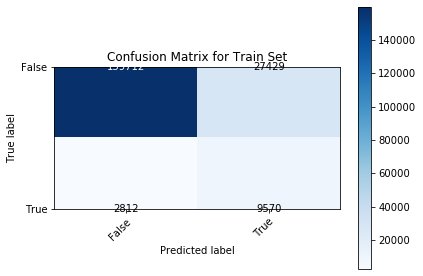

In [56]:
# Plot confusion matrix for the train set
plot_confusion_matrix(y_true_train, y_pred_train, normalize=False, classes=[False, True], 
                      title="Confusion Matrix for Train Set")

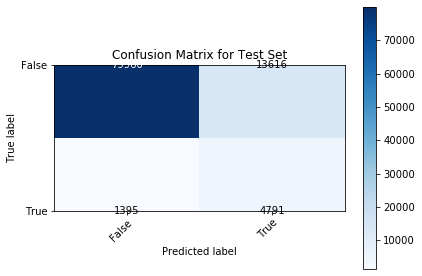

In [55]:
# Plot confusion matrix for the test set
plot_confusion_matrix(y_true_test, y_pred_test, normalize=False, classes=[False, True], 
                      title="Confusion Matrix for Test Set")

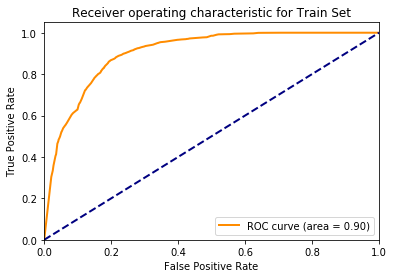

In [67]:
# Plot ROC curve for the train set.
plot_roc_auc(y_true_train, y_score_train, set="Train Set")

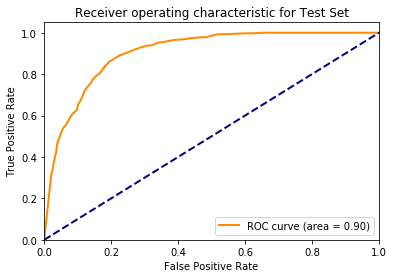

In [66]:
# Plot ROC curve for the test set.
plot_roc_auc(y_true_test, y_score_test)

In [69]:
# Kill the session and release resources
sc.stop()
